# 0. Importing Modules

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import distributions
import datetime
import pandas as pd
import pandas_datareader.data as pdr
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import RollingForecastCV, cross_val_predict
from options_chains import OptionsChain
import py_vollib.black_scholes as black_scholes_merton
import py_vollib_vectorized
from models import ARIMAForecastModel
from options_chains import OptionsChain

/Users/tayo4pf/Documents/Forecasting Implied Volatility with Machine Learning Techniques/arm_venv/lib/python3.10/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


# 1. Testing ARIMA Model on Returns Datasets

Because ARIMA is a model used to predict the mean of a random time series random variable, and therefore does not explicitly model volatility, I expect that it is unlikely that it will be be able to solely produce accurate option valuations.
This is because it is currently believed that it is reasonable to model mainstream securities as having a constant mean returns, and the process of volatility change is the factor of greater interest in option pricing. Nonetheless I will still produce forecasts with it to evaluate its efficacy by itself.

In [2]:
"""
Making training, and testing datasets
Training set is SPY returns from 2014 to 2019
Testing set is SPY returns in 2019 to 2020
"""
start = datetime.datetime(2014,1,1)
split_date = datetime.datetime(2019,1,1)
end = datetime.datetime(2020,1,1)
window = 21
spy_returns = distributions.get_returns(["SPY"], "2014-01-01", "2020-01-01")
spy_data = pd.DataFrame({"Log Returns":spy_returns})
spy_data = spy_data.dropna(axis=0, how="all")
spy_data.index = pd.to_datetime(spy_data.index)
spy_data["Realized Volatility"] = distributions.get_realized_volatility(spy_data["Log Returns"],21)

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

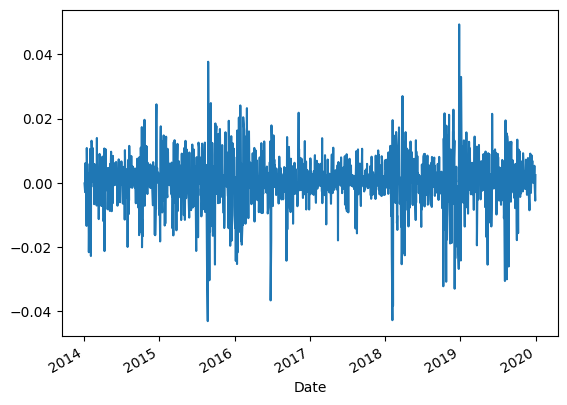

In [3]:
# Presenting train and test dataset
spy_data["Log Returns"].plot()

## 1.1 Non-Seasonal ARIMA Model for SPY

In [4]:
model = pm.arima.ARIMA(order=(3,2,3))
res = model.fit(spy_data["Log Returns"][:split_date])
res.summary()

/Users/tayo4pf/Documents/Forecasting Implied Volatility with Machine Learning Techniques/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Documents/Forecasting Implied Volatility with Machine Learning Techniques/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Documents/Forecasting Implied Volatility with Machine Learning Techniques/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/t

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1257
Model:               SARIMAX(3, 2, 3)   Log Likelihood                3988.954
Date:                Sun, 14 Apr 2024   AIC                          -7961.908
Time:                        15:26:39   BIC                          -7920.828
Sample:                             0   HQIC                         -7946.468
                               - 1257                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -2.05e-06   1.63e-05     -0.126      0.900    -3.4e-05    2.99e-05
ar.L1         -1.6462      0.108    -15.238      0.000      -1.858      -1.435
ar.L2         -1.2713      0.097    -13.083      0.000      -1.462      -1.081
ar.L3         -0.3998      0.043     -9.397      0.000      -0.483      -0.316
ma.L1          0.0704      0.106      0.664      0.506      -0.137       0.278
ma.L2         -0.5850      0.103     -5.653      0.000      -0.788      -0.382
ma.L3         -0.4319      0.072     -6.031      0.000      -0.572      -0.292
sigma2         0.0001   3.33e-06     30.391      0.000    9.47e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                  13.51   Jarque-Bera (JB):              1663.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.65
Prob(H) (two-sided):                  0.20   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

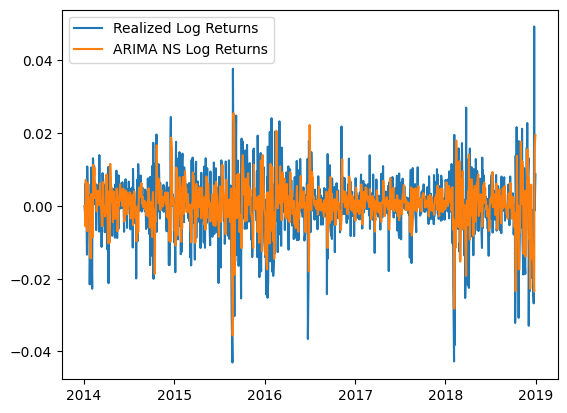

In [5]:
# Presenting train dataset model fit on returns
plt.plot(spy_data["Log Returns"][:split_date])
plt.plot(pd.DataFrame({"Log Returns":res.predict_in_sample()}, index = spy_data.index))
plt.legend(["Realized Log Returns", "ARIMA NS Log Returns"])

Text(0.5, 1.0, 'ARIMA Predicted Volatility vs. Realized Volatility from Training Data')

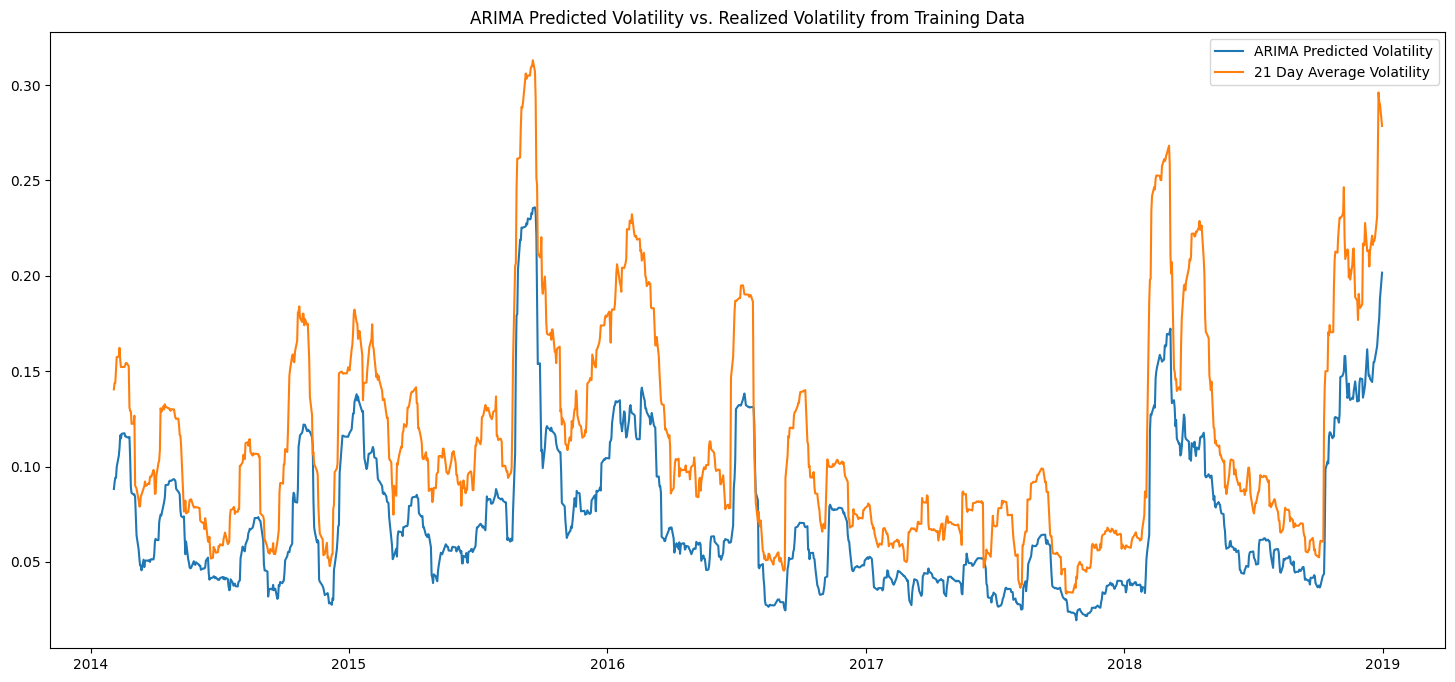

In [6]:
# Comparing realized volatility of the model fit to training data to realized volatility 
fig = plt.figure(figsize=(18,8))
plt.plot(distributions.get_realized_volatility(pd.DataFrame({"Log Returns":res.predict_in_sample()}), window))
plt.plot(spy_data["Realized Volatility"][:split_date])
plt.legend(["ARIMA Predicted Volatility", "21 Day Average Volatility"])
plt.title("ARIMA Predicted Volatility vs. Realized Volatility from Training Data")

/Users/tayo4pf/Documents/Forecasting Implied Volatility with Machine Learning Techniques/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tayo4pf/Documents/Forecasting Implied Volatility with Machine Learning Techniques/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


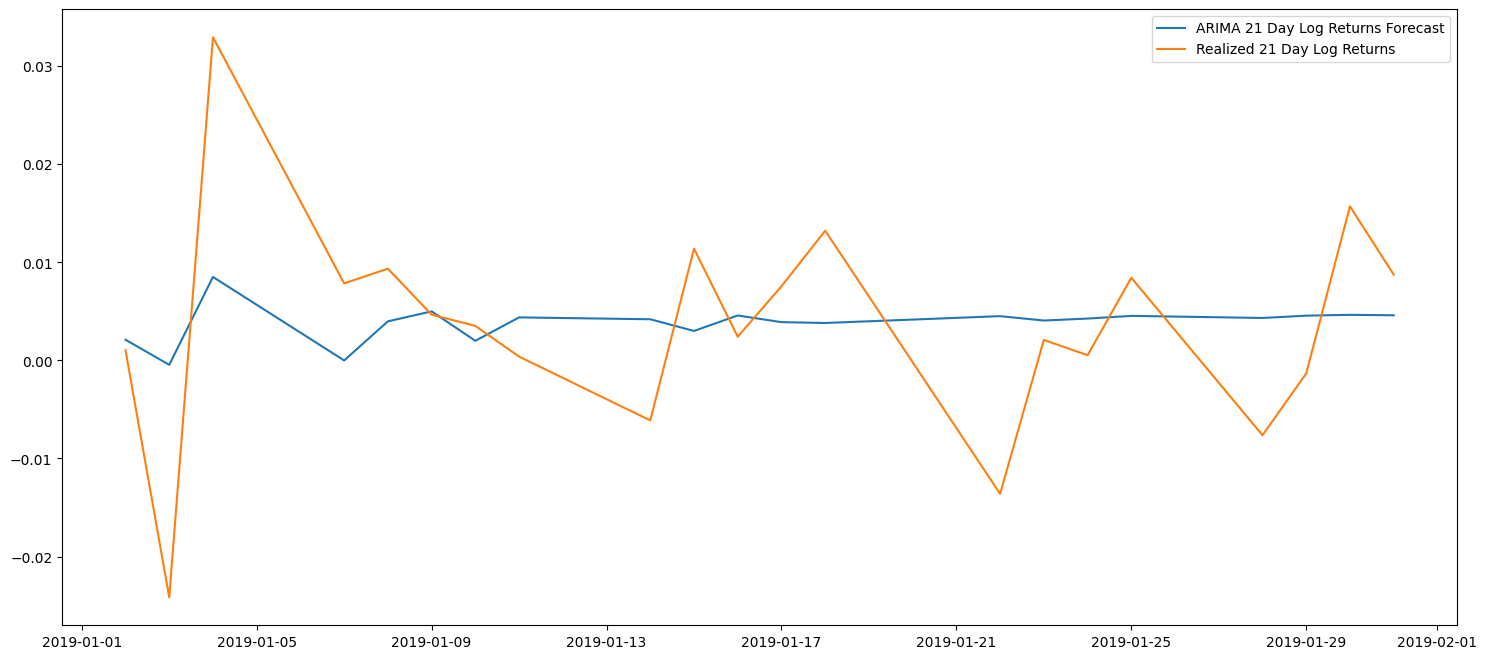

In [7]:
# 21 Day Forecast
fig = plt.figure(figsize=(18,8))

# Forecast returns for 21 days following split date
forecast_returns_window = pd.DataFrame({"Log Returns": res.predict(n_periods=window)})
forecast_returns_window = forecast_returns_window.set_index(spy_data[split_date:][:window].index)

plt.plot(forecast_returns_window)
plt.plot(spy_data["Log Returns"][split_date:][:window])
plt.legend(["ARIMA 21 Day Log Returns Forecast", "Realized 21 Day Log Returns"])

In [8]:
cv = RollingForecastCV(h=21, step=1, initial=len(spy_data["Log Returns"][:split_date]))
preds = cross_val_predict(pm.ARIMA((3,2,3)), y=spy_data["Log Returns"], cv=cv, return_raw_predictions=True)
arima_ns_forecasted_volatility = np.std(preds, axis=1, ddof=0)*np.sqrt(252)
arima_ns_forecasted_returns = preds[:,-1]
arima_ns_forecast = pd.DataFrame({
    "Forecasted Realized Volatility": arima_ns_forecasted_volatility,
    "Forecasted Log Returns": arima_ns_forecasted_returns
    }, index=spy_data.index)
arima_ns_forecast = arima_ns_forecast.shift(21)

/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tayo

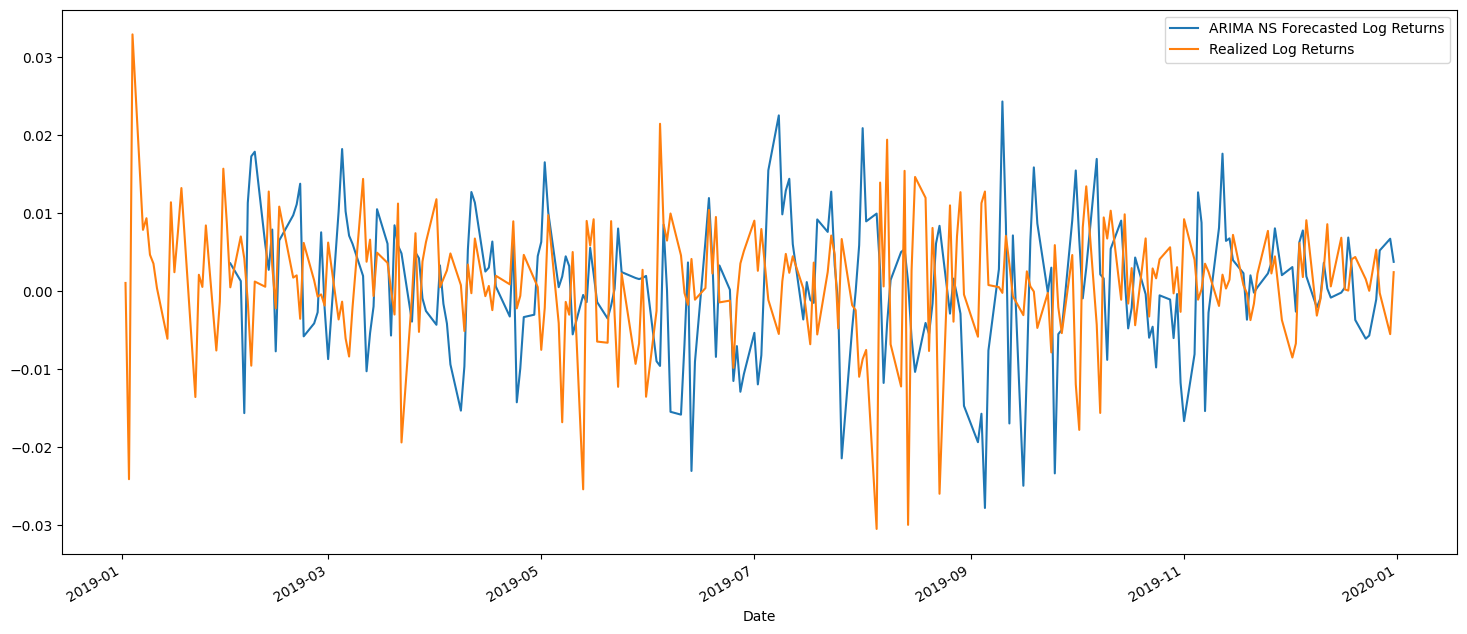

In [9]:
# TODO: 21 Plots, one for each forecast timestep
plt.figure(figsize=(18,8))
ax = plt.axes()
arima_ns_forecast["Forecasted Log Returns"].plot(ax=ax)
spy_data["Log Returns"][split_date:].plot(ax=ax)
plt.legend(["ARIMA NS Forecasted Log Returns", "Realized Log Returns"])

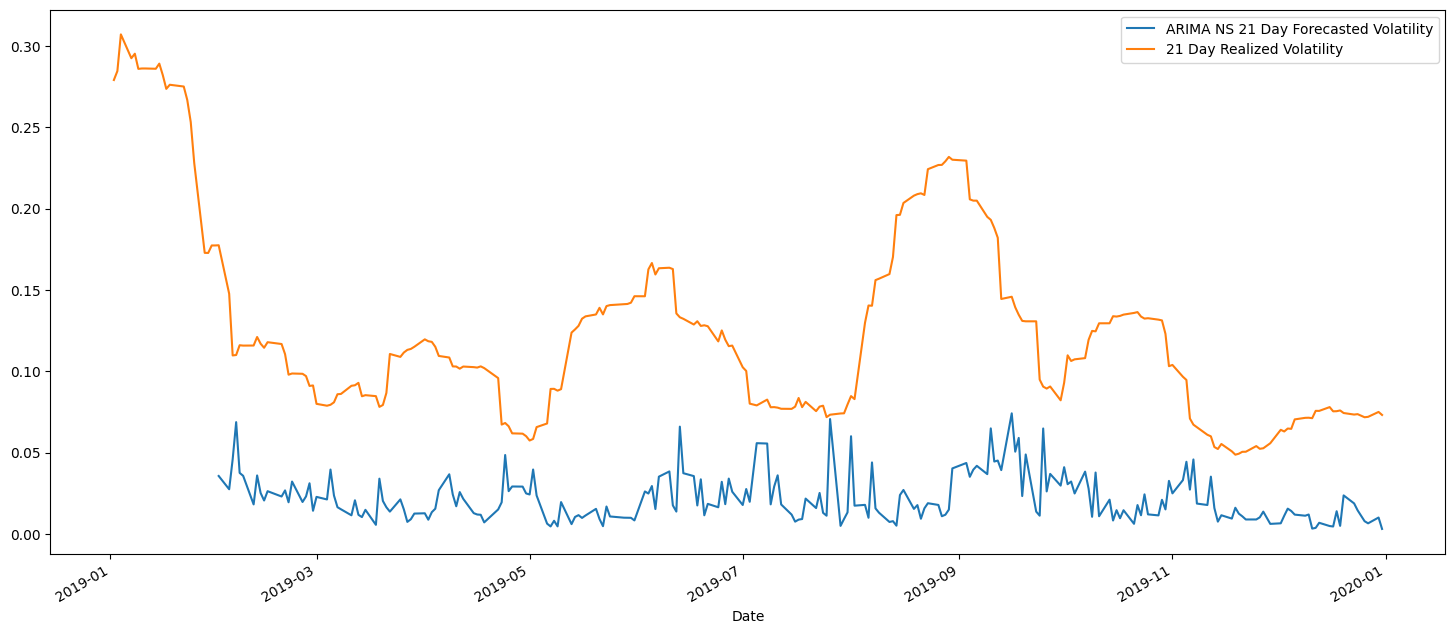

In [10]:
plt.figure(figsize=(18,8))
ax = plt.axes()
arima_ns_forecast["Forecasted Realized Volatility"].plot(ax=ax)
spy_data["Realized Volatility"][split_date:].plot(ax=ax)
plt.legend(["ARIMA NS 21 Day Forecasted Realized Volatility", "21 Day Realized Volatility"])

## 1.2 Seasonal ARIMA Model for SPY

In [12]:
model = pm.arima.ARIMA(order=(2,1,2), seasonal_order=(2,1,2,4))
res = model.fit(spy_data["Log Returns"][:split_date])
res.summary()

/Users/tayo4pf/Documents/Forecasting Implied Volatility with Machine Learning Techniques/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Documents/Forecasting Implied Volatility with Machine Learning Techniques/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1257
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 4)   Log Likelihood                4081.932
Date:                           Sun, 14 Apr 2024   AIC                          -8143.863
Time:                                   16:08:07   BIC                          -8092.538
Sample:                                        0   HQIC                         -8124.570
                                          - 1257                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.142e-06    2.5e-05     -0.046      0.964   -5.02e-05    4.79e-05
ar.L1         -0.7802      0.102     -7.635      0.000      -0.980      -0.580
ar.L2         -0.2575      0.023    -11.269      0.000      -0.302      -0.213
ma.L1         -0.1634      0.102     -1.605      0.108      -0.363       0.036
ma.L2         -0.4611      0.100     -4.602      0.000      -0.657      -0.265
ar.S.L4       -0.6556      0.415     -1.580      0.114      -1.469       0.158
ar.S.L8       -0.1383      0.074     -1.877      0.060      -0.283       0.006
ma.S.L4       -0.3887      0.421     -0.923      0.356      -1.214       0.437
ma.S.L8       -0.3689      0.363     -1.016      0.310      -1.080       0.343
sigma2      8.557e-05   2.41e-06     35.530      0.000    8.09e-05    9.03e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               856.77
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.27
Prob(H) (two-sided):                  0.15   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

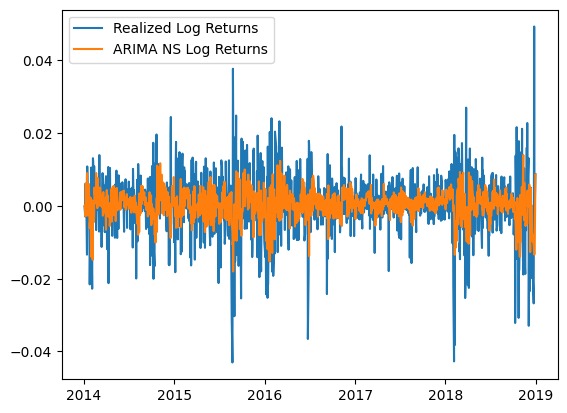

In [13]:
plt.plot(spy_data["Log Returns"][:split_date])
plt.plot(pd.DataFrame({"Log Returns":res.predict_in_sample()}, index = spy_data.index))
plt.legend(["Realized Log Returns", "ARIMA NS Log Returns"])

Text(0.5, 1.0, 'ARIMA Predicted Volatility vs. Realized Volatility from Training Data')

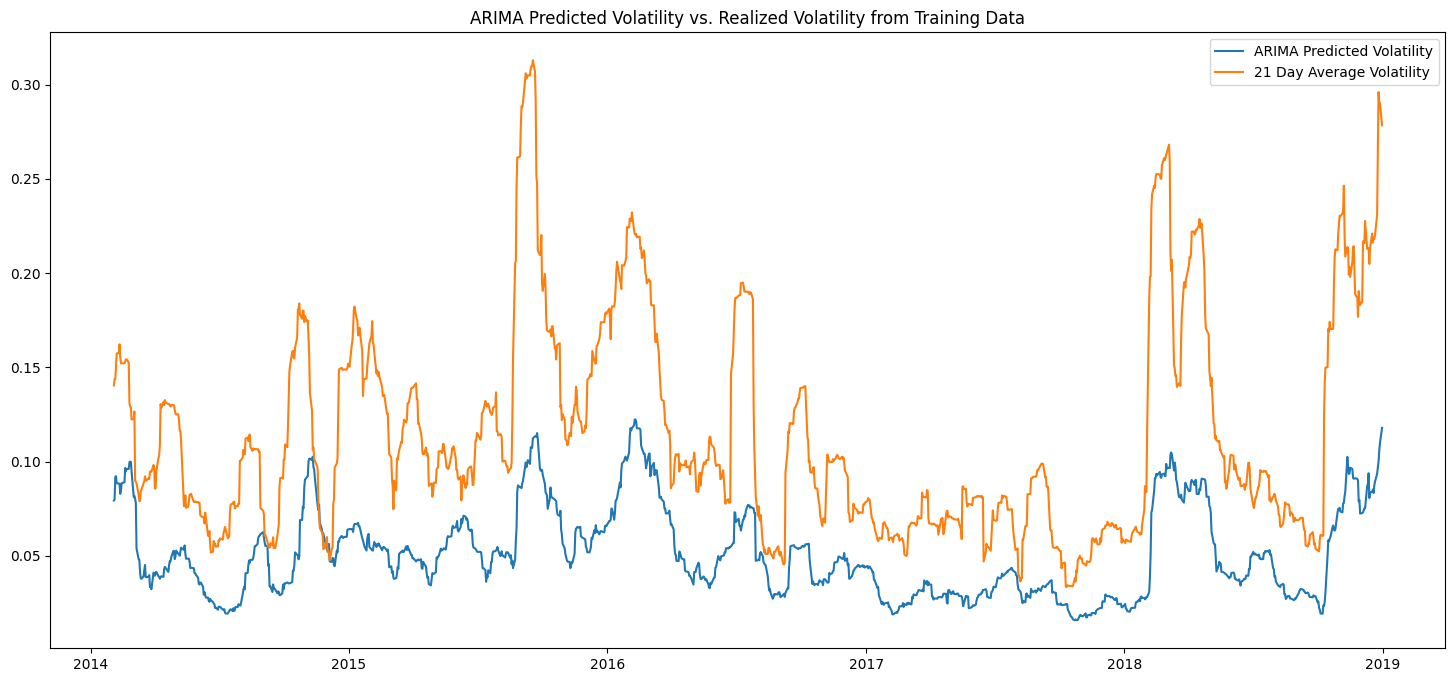

In [14]:
fig = plt.figure(figsize=(18,8))
plt.plot(distributions.get_realized_volatility(pd.DataFrame({"Log Returns":res.predict_in_sample()}), window))
plt.plot(spy_data["Realized Volatility"][:split_date])
plt.legend(["ARIMA Predicted Volatility", "21 Day Average Volatility"])
plt.title("ARIMA Predicted Volatility vs. Realized Volatility from Training Data")

# 2 Contract Simulation

In [25]:
res.arima_res_.simulate(nsimulations=10)/100

Date
2014-01-03     21.830406
2014-01-06     31.481779
2014-01-07     41.162863
2014-01-08     50.817961
2014-01-09     60.476184
2014-01-10     70.150037
2014-01-13     79.796190
2014-01-14     89.463895
2014-01-15     99.109969
2014-01-16    108.785101
Name: y, dtype: float64

In [23]:
options = OptionsChain("SPY", 2019)

In [24]:
iv_dist = options.iv_dist(21, 0.45, 0.55)
ask_dist = options.ask_dist(21, 0.45, 0.55)
bid_dist = options.bid_dist(21, 0.45, 0.55)

# 2.1 ARIMA Non-Seasonal Simulation

# 2.1.0 Creating Simulations

In [2]:
arima_forecaster = ARIMAForecastModel("SPY", "2014-01-01", "2020-01-01", "2019-01-01", 21, (2,0,2))
arima_forecaster.forecaster(21)
simulator = arima_forecaster.simulation(21)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

In [3]:
arima_forecaster.options_pricing(simulator, 1).head()

,Call Price ATM,Realized Call Value ATM,Put Price ATM,Realized Put Value ATM,Underlying Price
Date,,,,,
2019-02-01,0.000293,18.320709,0.000465,0.0,230.557465
2019-02-04,0.000241,25.573395,0.000288,0.0,225.055725
2019-02-05,0.000402,19.085587,0.000193,0.0,232.594101
2019-02-06,0.000458,16.919952,0.000119,0.0,234.428040
2019-02-07,0.000297,12.321335,0.000352,0.0,236.630600
